In [1]:
from transformers import LlamaTokenizerFast, BertTokenizerFast, AutoTokenizer
from tqdm import tqdm
from datasets import load_dataset

llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
# tokenizer_bloom = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
# tokenizer_Bert = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")


/opt/anaconda3/envs/llama/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Tokenizer by language

In [2]:

def calculate_corpus_fertility(dataset_name, language_code, tokenizer, split='dev', max_docs=10000):
    """
    Calculate fertility for a dataset and tokenizer.

    Args:
        dataset_name (str): The dataset to load.
        language_code (str): The specific language code for the dataset.
        tokenizer_name (str): The tokenizer to use.
        split (str): The split of the dataset to evaluate (default: "train").
        max_docs (int): Maximum number of documents to evaluate (default: 10,000).

    Returns:
        float: The fertility score for the tokenizer on the dataset.
    """
    # Load dataset and tokenizer
    dataset = load_dataset(dataset_name, language_code, split=split)

    total_tokens = 0
    total_words = 0

    # Process up to max_docs
    for i, example in enumerate(tqdm(dataset, desc=f"Calculating fertility for {language_code}")):
        if i >= max_docs:
            break

        # Combine all text fields
        question = example["question"]
        choices = " ".join(eval(example["choices"]))  # Combine choices into a string
        answer = example["answer"]
        combined_text = f"{question} {choices} {answer}"

        # Tokenize and count tokens
        tokenized = tokenizer.tokenize(combined_text)
        total_tokens += len(tokenized)

        # Count words using whitespace splitting
        total_words += len(combined_text.split())

    # Compute fertility
    if total_words == 0:
        raise ValueError("Total words in the dataset is zero. Cannot compute fertility.")

    fertility = total_tokens / total_words
    return fertility

# Example usage
dataset_name = "masakhane/afrimmlu"
language_code = "eng"  # Example: Swahili
split = "dev"  # Use "train" or any available split

fertility_score = calculate_corpus_fertility(dataset_name, language_code, llama_tokenizer, split=split,)
print(fertility_score)

Calculating fertility for eng: 100%|██████████| 25/25 [00:00<00:00, 4233.08it/s]

1.2259615384615385


In [3]:
import os
import pandas as pd
import re

# Define the folder path
path = './llm_outputs/llama3_405B'

# List all .tsv files in the folder
tsv_files = [f for f in os.listdir(path) if f.endswith('.tsv')]

# Dictionary to store the DataFrame of accuracies for each file
file_subject_accuracies = {}

# Process each TSV file
for tsv_file in tsv_files:
    file_path = os.path.join(path, tsv_file)
    try:
        # Read the TSV file with error handling
        data = pd.read_csv(file_path, sep='\t', on_bad_lines='warn')
        
        # Ensure the data contains the required columns
        expected_columns = ['question', 'choices', 'answer', 'subject', 'llm']
        if not all(col in data.columns for col in expected_columns):
            print(f"Skipping {tsv_file} due to missing columns.")
            continue

        # Initialize an empty list to hold accuracy values for each record
        accuracy_records = []

        # Check if the `answer` is in the `llm` column for each row
        for _, row in data.iterrows():
            # Use regex to extract only the letter part (A, B, C, etc.) from the llm column
            llm_answers = [match.group(1) for match in re.finditer(r'([A-Za-z])\)', str(row['llm']))]

            # Check if the answer exists in the llm choices (only comparing the letter part)
            is_correct = 1 if row['answer'].strip() in llm_answers else 0
            accuracy_records.append(is_correct)
        
        # Add the accuracy as a new column to the DataFrame
        data['accuracy'] = accuracy_records

        # Store the updated DataFrame in the dictionary
        file_subject_accuracies[tsv_file] = data

        # Save the DataFrame with accuracy to a CSV file named after the language (file name without extension)
        language_name = os.path.splitext(tsv_file)[0]  # Remove '.tsv' extension
        save_path = os.path.join(path, f"{language_name}_accuracy.csv")
        data.to_csv(save_path, index=False)
    
    except Exception as e:
        print(f"Error processing {tsv_file}: {e}")


In [4]:
import os

# Define the folder path where files are saved
path = './llm_outputs/llama3_405B'

# List all files ending with "_accuracy.csv"
created_files = [f for f in os.listdir(path) if f.endswith('_accuracy.csv')]

# Print the list of created files
print("List of accuracy files created:")
for file in created_files:
    print(file)


List of accuracy files created:
amh_accuracy.csv
twi_accuracy.csv
hau_accuracy.csv
xho_accuracy.csv
zul_accuracy.csv
lin_accuracy.csv
sna_accuracy.csv
kin_accuracy.csv
ewe_accuracy.csv
orm_accuracy.csv
lug_accuracy.csv
yor_accuracy.csv
wol_accuracy.csv
ibo_accuracy.csv
swa_accuracy.csv
eng_accuracy.csv
fra_accuracy.csv
sot_accuracy.csv


In [5]:
import pandas as pd
# List all the accuracy CSV files
accuracy_files = [f for f in os.listdir(path) if f.endswith('_accuracy.csv')]

# Initialize a list to hold individual DataFrames
dfs = []

# Loop through each CSV file and load it into a DataFrame
for accuracy_file in accuracy_files:
    file_path = os.path.join(path, accuracy_file)
    try:
        # Load the CSV into a DataFrame
        df = pd.read_csv(file_path)
        
        # Add a column to the DataFrame for the file name (language)
        df['language'] = accuracy_file.replace('_accuracy.csv', '')  # Remove '_accuracy.csv' to get the language name
        
        # Add the DataFrame to the list
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {accuracy_file}: {e}")

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True).drop(columns=["Unnamed: 0"])

# Display the resulting DataFrame
(combined_df)


,question,choices,answer,subject,llm,accuracy,language
0,በ 24 = 2p ውስጥ የ p ዋጋ ስንት ነው,"['p = 5', 'p = 9', 'p = 13', 'p = 25']",C,elementary_mathematics,በ 24 = 2p \n\nበ 24 = 2 * 12 \n\nበ 24 / 2 = 12 ...,0,amh
1,ወይዘሮ ፔሬዝ በ5 ቀናት ውስጥ በአጠቃላይ 40 ማይል ነድታለች። በየቀኑ ...,"['5', '7', '8', '9']",C,elementary_mathematics,C) 8,1,amh
2,የ −40 ÷ (−8) ድርሻ ፈልጉ,"['1 ሲካፈል 5', '-5', '−1 ሲካፈል 5', '5']",D,elementary_mathematics,D) 5,1,amh
3,የእግር ኳስ ቡድን የእግር ኳስ ኳሶችን ለመግዛት $90.00 አለው። አንድ...,"['4', '5', '6', '7']",B,elementary_mathematics,B) 5,1,amh
4,አንተ እና ሶስት ጓደኞች ወደ ኮንሰርት ሄዳችሁ። የአራት ትኬቶች አጠቃላይ...,"['4t = 112; $449', '4t = 112; $29', 't over 4 ...",B,elementary_mathematics,B) 4t = 112; $28,1,amh
...,...,...,...,...,...,...,...
8995,Ho fokotswa ha meputso e fokolang tlhahisong y...,['sehlahiswa se tlwaelehileng sa mosebetsi se ...,D,high_school_microeconomics,B) Kakaretso ya ho etsa sehlahiswa e qala ho wa,0,sot
8996,Seo o se telang ho tswellisa tsela e nngwe e b...,"['tjhelete.', 'lefatshe', 'ditjeho tsa tjhelet...",D,high_school_microeconomics,D) ditjeho tsa monyetla,1,sot
8997,Ke efe ho tse latelang e senang tshobotsi ya i...,"['Ho kena mahala indastering.', 'Product diffe...",B,high_school_microeconomics,D) dihlahiswa tse tshwanang,0,sot
8998,E amana le mmaraka wa basebetsi o nang le more...,"['e lefa hanyane mme e hira haholo', 'e lefa h...",D,high_school_microeconomics,A) e lefa hanyane mme e hira haholo,0,sot


In [6]:
combined_df.groupby(['language']).agg(
    mean_accuracy=('accuracy', 'mean'))

,mean_accuracy
language,
amh,0.628
eng,0.870
ewe,0.414
fra,0.818
hau,0.546
ibo,0.578
kin,0.524
lin,0.500
lug,0.464


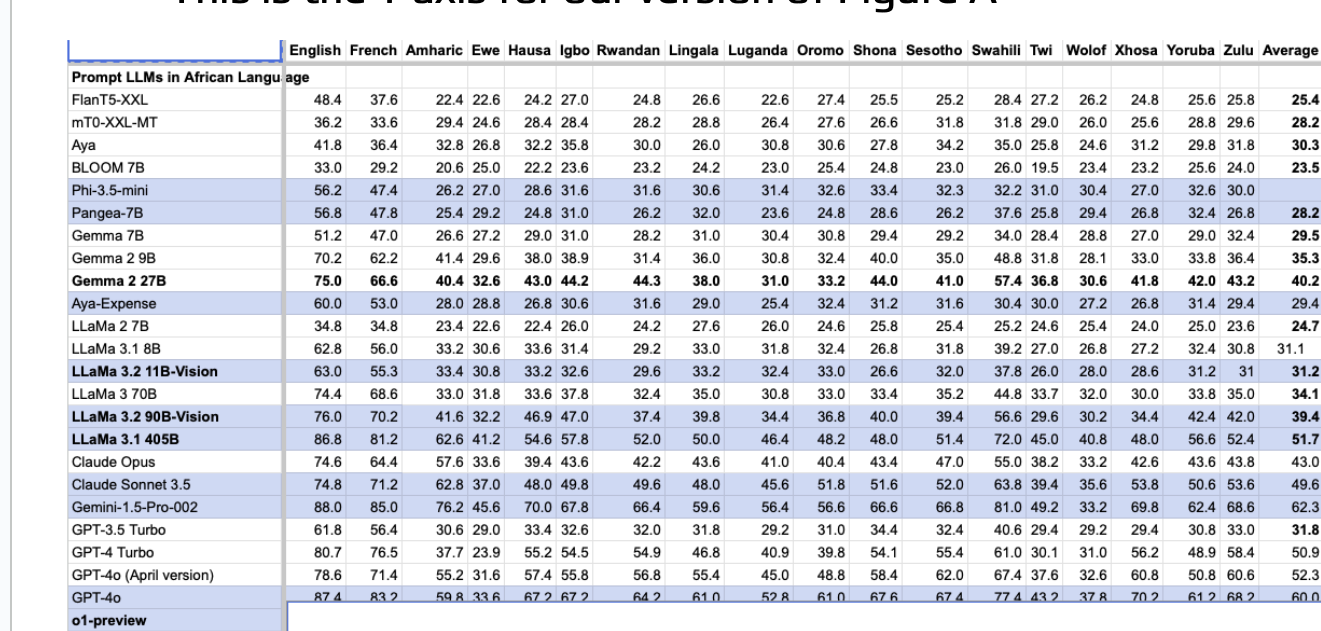

In [7]:
from collections import defaultdict

def calculate_fertility_by_subject(dataset_name, language_code, tokenizer, split='dev', max_docs=10000):
    """
    Calculate fertility for each subject in the dataset for a given tokenizer.

    Args:
        dataset_name (str): The dataset to load.
        language_code (str): The specific language code for the dataset.
        tokenizer (Tokenizer): The tokenizer to use.
        split (str): The split of the dataset to evaluate (default: "dev").
        max_docs (int): Maximum number of documents to evaluate (default: 10,000).

    Returns:
        dict: A dictionary where keys are subjects and values are fertility scores for that subject.
    """
    # Load dataset
    dataset = load_dataset(dataset_name, language_code, split=split)

    # Dictionary to store total tokens, total words by subject
    subject_fertility = defaultdict(lambda: {"tokens": 0, "words": 0})

    # Process up to max_docs
    for i, example in enumerate(tqdm(dataset, desc=f"Calculating fertility for {language_code}")):
        if i >= max_docs:
            break

        # Combine all text fields
        question = example["question"]
        choices = " ".join(eval(example["choices"]))  # Combine choices into a string
        answer = example["answer"]
        combined_text = f"{question} {choices} {answer}"

        # Get the subject
        subject = example.get("subject", "unknown")  # Default to "unknown" if no subject is provided

        # Tokenize and count tokens
        tokenized = tokenizer.tokenize(combined_text)
        subject_fertility[subject]["tokens"] += len(tokenized)

        # Count words using whitespace splitting
        subject_fertility[subject]["words"] += len(combined_text.split())

    # Compute fertility for each subject
    fertility_by_subject = {}
    for subject, counts in subject_fertility.items():
        if counts["words"] == 0:
            fertility_by_subject[subject] = None  # Handle cases with no words
        else:
            fertility_by_subject[subject] = counts["tokens"] / counts["words"]

    return fertility_by_subject

# Example usage
dataset_name = "masakhane/afrimmlu"
language_code = "amh"  # Example: English
split = "test"  # Use "train" or any available split

fertility_scores = calculate_fertility_by_subject(dataset_name, language_code, llama_tokenizer, split=split)

# Print the fertility scores for each subject
for subject, fertility in fertility_scores.items():
    print(f"Subject: {subject}, Fertility: {fertility}")


Calculating fertility for amh: 100%|██████████| 500/500 [00:00<00:00, 4231.16it/s]

Subject: elementary_mathematics, Fertility: 7.225614591593973
Subject: high_school_geography, Fertility: 11.386834620073142
Subject: international_law, Fertility: 11.635664729045565
Subject: global_facts, Fertility: 9.212037765538946
Subject: high_school_microeconomics, Fertility: 11.120859213250517


These fertility scores have been generated using the LLama Tokenizer.

In [8]:
from collections import defaultdict
from datasets import load_dataset
from tqdm import tqdm

def calculate_fertility_by_subject(dataset_name, language_code, tokenizer, split='dev', max_docs=10000):
    """
    Calculate fertility for each subject in the dataset for a given tokenizer, averaging fertility per record.

    Args:
        dataset_name (str): The dataset to load.
        language_code (str): The specific language code for the dataset.
        tokenizer (Tokenizer): The tokenizer to use.
        split (str): The split of the dataset to evaluate (default: "dev").
        max_docs (int): Maximum number of documents to evaluate (default: 10,000).

    Returns:
        dict: A dictionary where keys are subjects and values are mean fertility scores for that subject.
    """
    # Load dataset
    dataset = load_dataset(dataset_name, language_code, split=split)

    # Dictionary to store fertility scores by subject
    subject_fertility = defaultdict(list)

    # Process up to max_docs
    for i, example in enumerate(tqdm(dataset, desc=f"Calculating fertility for {language_code}")):
        if i >= max_docs:
            break

        # Combine all text fields
        question = example["question"]
        choices = " ".join(eval(example["choices"]))  # Combine choices into a string
        answer = example["answer"]
        combined_text = f"{question} {choices} {answer}"

        # Get the subject
        subject = example.get("subject", "unknown")  # Default to "unknown" if no subject is provided

        # Tokenize and count tokens
        tokenized = tokenizer.tokenize(combined_text)
        total_tokens = len(tokenized)

        # Count words using whitespace splitting
        total_words = len(combined_text.split())

        # Calculate fertility for this record
        if total_words > 0:
            record_fertility = total_tokens / total_words
            subject_fertility[subject].append(record_fertility)

    # Compute mean fertility for each subject
    fertility_by_subject = {}
    for subject, fertility_list in subject_fertility.items():
        if fertility_list:
            mean_fertility = sum(fertility_list) / len(fertility_list)
            fertility_by_subject[subject] = mean_fertility
        else:
            fertility_by_subject[subject] = None  # Handle cases with no valid records

    return fertility_by_subject

# Example usage
dataset_name = "masakhane/afrimmlu"
language_code = "amh"  # Example: Amharic
split = "test"  # Use "train" or any available split

# Assuming llama_tokenizer is already defined
fertility_scores = calculate_fertility_by_subject(dataset_name, language_code, llama_tokenizer, split=split)

# Print the fertility scores for each subject
for subject, fertility in fertility_scores.items():
    print(f"Subject: {subject}, Mean Fertility: {fertility}")


Calculating fertility for amh: 100%|██████████| 500/500 [00:00<00:00, 4577.76it/s]

Subject: elementary_mathematics, Mean Fertility: 6.618265109423613
Subject: high_school_geography, Mean Fertility: 11.416266907711123
Subject: international_law, Mean Fertility: 11.621503332448158
Subject: global_facts, Mean Fertility: 8.81507549127439
Subject: high_school_microeconomics, Mean Fertility: 11.27362945026319


In [9]:
languages = {
    "amh": "Amharic",
    "eng": "English",
    "ewe": "Ewe",
    "fra": "French",
    "hau": "Hausa",
    "ibo": "Igbo",
    "kin": "Kinyarwanda",
    "lin": "Lingala",
    "lug": "Luganda",
    "orm": "Oromo",
    "sna": "Shona",
    "sot": "Southern Sotho",
    "swa": "Swahili",
    "twi": "Twi",
    "wol": "Wolof",
    "xho": "Xhosa",
    "yor": "Yoruba",
    "zul": "Zulu",
}

results_llama_Tokenizer = {}

# Process each language
for lang_code, lang_name in languages.items():
    try:
        print(f"Processing language: {lang_name} ({lang_code})")

        # Calculate fertility for each subject
        fertility_scores_by_subject = calculate_fertility_by_subject(
            dataset_name, lang_code, llama_tokenizer, split='test'
        )

        # Store results for this language
        results_llama_Tokenizer[lang_code] = fertility_scores_by_subject

        # Print the fertility scores for each subject in the language
        print(f"Fertility Scores for {lang_name}:")
        for subject, fertility in fertility_scores_by_subject.items():
            print(f"  {subject}: {fertility}")

    except Exception as e:
        print(f"Failed for {lang_name} ({lang_code}): {e}")

# Print all fertility results by language
print("\nFertility Scores by Language:")
for lang_code, fertility_scores in results_llama_Tokenizer.items():
    print(f"\n{languages[lang_code]} ({lang_code}):")
    for subject, fertility in fertility_scores.items():
        print(f"  {subject}: {fertility}")


Processing language: Amharic (amh)


Calculating fertility for amh: 100%|██████████| 500/500 [00:00<00:00, 4722.33it/s]


Fertility Scores for Amharic:
  elementary_mathematics: 6.618265109423613
  high_school_geography: 11.416266907711123
  international_law: 11.621503332448158
  global_facts: 8.81507549127439
  high_school_microeconomics: 11.27362945026319
Processing language: English (eng)


Calculating fertility for eng: 100%|██████████| 500/500 [00:00<00:00, 7374.83it/s]


Fertility Scores for English:
  global_facts: 1.502415919754385
  international_law: 1.141640819613101
  high_school_microeconomics: 1.1897342393052575
  high_school_geography: 1.25276723252631
  elementary_mathematics: 1.6125070664404553
Processing language: Ewe (ewe)


Calculating fertility for ewe: 100%|██████████| 500/500 [00:00<00:00, 5722.51it/s]


Fertility Scores for Ewe:
  elementary_mathematics: 2.484956948323281
  high_school_geography: 3.329235290331567
  international_law: 3.236221415635001
  global_facts: 2.7404202745004405
  high_school_microeconomics: 3.0915643156041837
Processing language: French (fra)


Calculating fertility for fra: 100%|██████████| 500/500 [00:00<00:00, 5996.85it/s]


Fertility Scores for French:
  elementary_mathematics: 1.8144701512606087
  high_school_geography: 1.8061010036442795
  international_law: 1.7063209811129534
  global_facts: 1.8037386201286048
  high_school_microeconomics: 1.6375617638307265
Processing language: Hausa (hau)


Calculating fertility for hau: 100%|██████████| 500/500 [00:00<00:00, 5375.47it/s]


Fertility Scores for Hausa:
  elementary_mathematics: 2.233852120665732
  high_school_geography: 2.377911958783671
  international_law: 2.455093578902046
  global_facts: 2.2607808307140504
  high_school_microeconomics: 2.2180590503846416
Processing language: Igbo (ibo)


Calculating fertility for ibo: 100%|██████████| 500/500 [00:00<00:00, 5235.05it/s]


Fertility Scores for Igbo:
  elementary_mathematics: 2.5507663070364455
  high_school_geography: 2.5797973112023107
  international_law: 2.5609670755088048
  global_facts: 2.4688929874830263
  high_school_microeconomics: 2.705340752680042
Processing language: Kinyarwanda (kin)


Calculating fertility for kin: 100%|██████████| 500/500 [00:00<00:00, 5279.39it/s]


Fertility Scores for Kinyarwanda:
  elementary_mathematics: 2.5452925465003173
  high_school_geography: 2.938164692121441
  international_law: 3.0548149456740323
  global_facts: 2.6377058116417165
  high_school_microeconomics: 3.0818166110319023
Processing language: Lingala (lin)


Calculating fertility for lin: 100%|██████████| 500/500 [00:00<00:00, 6163.94it/s]


Fertility Scores for Lingala:
  elementary_mathematics: 1.9369339356144653
  high_school_geography: 1.8503016498120437
  international_law: 1.8495512928452695
  global_facts: 1.9661287323416798
  high_school_microeconomics: 1.832664935648298
Processing language: Luganda (lug)


Calculating fertility for lug: 100%|██████████| 500/500 [00:00<00:00, 5434.08it/s]


Fertility Scores for Luganda:
  elementary_mathematics: 2.5998557617462104
  high_school_geography: 3.2254471373436484
  international_law: 3.251701038824911
  global_facts: 2.804329606917695
  high_school_microeconomics: 3.3431486340571848
Processing language: Oromo (orm)


Calculating fertility for orm: 100%|██████████| 500/500 [00:00<00:00, 6838.00it/s]


Fertility Scores for Oromo:
  elementary_mathematics: 2.6530811242343346
  high_school_geography: 3.204985059136748
  international_law: 3.1144277296822396
  global_facts: 3.0277192484090296
  high_school_microeconomics: 3.072062460186095
Processing language: Shona (sna)


Calculating fertility for sna: 100%|██████████| 500/500 [00:00<00:00, 5560.17it/s]


Fertility Scores for Shona:
  elementary_mathematics: 2.5877519738137864
  high_school_geography: 3.011130138956464
  international_law: 3.1411514330264616
  global_facts: 3.0290303959024687
  high_school_microeconomics: 3.325363303345077
Processing language: Southern Sotho (sot)


Calculating fertility for sot: 100%|██████████| 500/500 [00:00<00:00, 6086.20it/s]


Fertility Scores for Southern Sotho:
  elementary_mathematics: 2.0658665187495413
  high_school_geography: 1.9379261349375734
  international_law: 2.0292923044397786
  global_facts: 2.1010118659702375
  high_school_microeconomics: 2.09399803292968
Processing language: Swahili (swa)


Calculating fertility for swa: 100%|██████████| 500/500 [00:00<00:00, 6073.93it/s]


Fertility Scores for Swahili:
  elementary_mathematics: 2.2444431788043486
  global_facts: 2.4473297525080535
  high_school_geography: 2.3779849194086844
  high_school_microeconomics: 2.3393598444427184
  international_law: 2.3243807499674474
Processing language: Twi (twi)


Calculating fertility for twi: 100%|██████████| 500/500 [00:00<00:00, 5193.99it/s]


Fertility Scores for Twi:
  elementary_mathematics: 2.647447287400322
  high_school_geography: 2.8707700420347595
  international_law: 2.7587105485242636
  global_facts: 2.6707694368753674
  high_school_microeconomics: 2.7035191386777244
Processing language: Wolof (wol)


Calculating fertility for wol: 100%|██████████| 500/500 [00:00<00:00, 5009.36it/s]


Fertility Scores for Wolof:
  elementary_mathematics: 2.0355537473333665
  high_school_geography: 2.0778271621976727
  international_law: 2.110933315725872
  global_facts: 2.148848473504225
  high_school_microeconomics: 2.0759118120702835
Processing language: Xhosa (xho)


Calculating fertility for xho: 100%|██████████| 500/500 [00:00<00:00, 5449.95it/s]


Fertility Scores for Xhosa:
  elementary_mathematics: 3.090959909563498
  high_school_geography: 3.587510351289824
  international_law: 3.777020456384522
  global_facts: 3.6167337657264476
  high_school_microeconomics: 3.5354153493835567
Processing language: Yoruba (yor)


Calculating fertility for yor: 100%|██████████| 500/500 [00:00<00:00, 4681.47it/s]


Fertility Scores for Yoruba:
  elementary_mathematics: 2.8247738013990222
  high_school_geography: 3.6318496460130008
  international_law: 3.215868074784305
  global_facts: 3.2471011513146117
  high_school_microeconomics: 3.1671180509432393
Processing language: Zulu (zul)


Calculating fertility for zul: 100%|██████████| 500/500 [00:00<00:00, 5550.74it/s]

Fertility Scores for Zulu:
  elementary_mathematics: 2.732889303578582
  high_school_geography: 3.5469100521772994
  international_law: 3.6861463163112678
  global_facts: 3.3802319056868213
  high_school_microeconomics: 3.668062861669859

Fertility Scores by Language:

Amharic (amh):
  elementary_mathematics: 6.618265109423613
  high_school_geography: 11.416266907711123
  international_law: 11.621503332448158
  global_facts: 8.81507549127439
  high_school_microeconomics: 11.27362945026319

English (eng):
  global_facts: 1.502415919754385
  international_law: 1.141640819613101
  high_school_microeconomics: 1.1897342393052575
  high_school_geography: 1.25276723252631
  elementary_mathematics: 1.6125070664404553

Ewe (ewe):
  elementary_mathematics: 2.484956948323281
  high_school_geography: 3.329235290331567
  international_law: 3.236221415635001
  global_facts: 2.7404202745004405
  high_school_microeconomics: 3.0915643156041837

French (fra):
  elementary_mathematics: 1.8144701512606087

In [10]:
def map_fertility(row):
    language = row['language']
    subject = row['subject']
    return results_llama_Tokenizer.get(language, {}).get(subject, None)  # Default to None if not found

# Apply the function to the DataFrame to create a new column 'fertility'
combined_df['fertility'] = combined_df.apply(map_fertility, axis=1)

# Display the updated DataFrame
# combined_df.to_csv('llama_per_subject_results.csv', index=False)


In [11]:
aggregated_df = combined_df.groupby(['language', 'subject']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_fertility=('fertility', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df)

,language,subject,mean_accuracy,mean_fertility
0,amh,elementary_mathematics,0.73,6.618265
1,amh,global_facts,0.53,8.815075
2,amh,high_school_geography,0.61,11.416267
3,amh,high_school_microeconomics,0.53,11.273629
4,amh,international_law,0.74,11.621503
...,...,...,...,...
85,zul,elementary_mathematics,0.68,2.732889
86,zul,global_facts,0.48,3.380232
87,zul,high_school_geography,0.53,3.546910
88,zul,high_school_microeconomics,0.37,3.668063


In [12]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming aggregated_df is already loaded and contains the necessary columns

# Group by 'subject' (language) and calculate Pearson correlation per group
correlations = {}

for language, group in aggregated_df.groupby('language'):
    corr, p_value = pearsonr(group['mean_accuracy'], group['mean_fertility'])
    correlations[language] = {'correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for easy viewing
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')

print(correlation_df)


     correlation   p_value
amh    -0.219365  0.722952
eng    -0.702725  0.185647
ewe    -0.620207  0.264373
fra    -0.586205  0.298898
hau     0.298094  0.626153
ibo    -0.500102  0.390890
kin    -0.378142  0.530268
lin     0.348696  0.565196
lug    -0.603472  0.281226
orm    -0.677217  0.209154
sna    -0.685919  0.201046
sot    -0.079463  0.898932
swa    -0.927286  0.023279
twi    -0.605876  0.278788
wol    -0.228512  0.711601
xho    -0.439906  0.458524
yor    -0.426571  0.473826
zul    -0.725354  0.165478


From the MEGA Paper " We report the curves for the cases where the person coefficient |ρ| > 0.7 with a p-value of 0.05. We have combined Indic- XNLI and XNLI for a better coverage of languages.
"

<Figure size 1200x800 with 0 Axes>

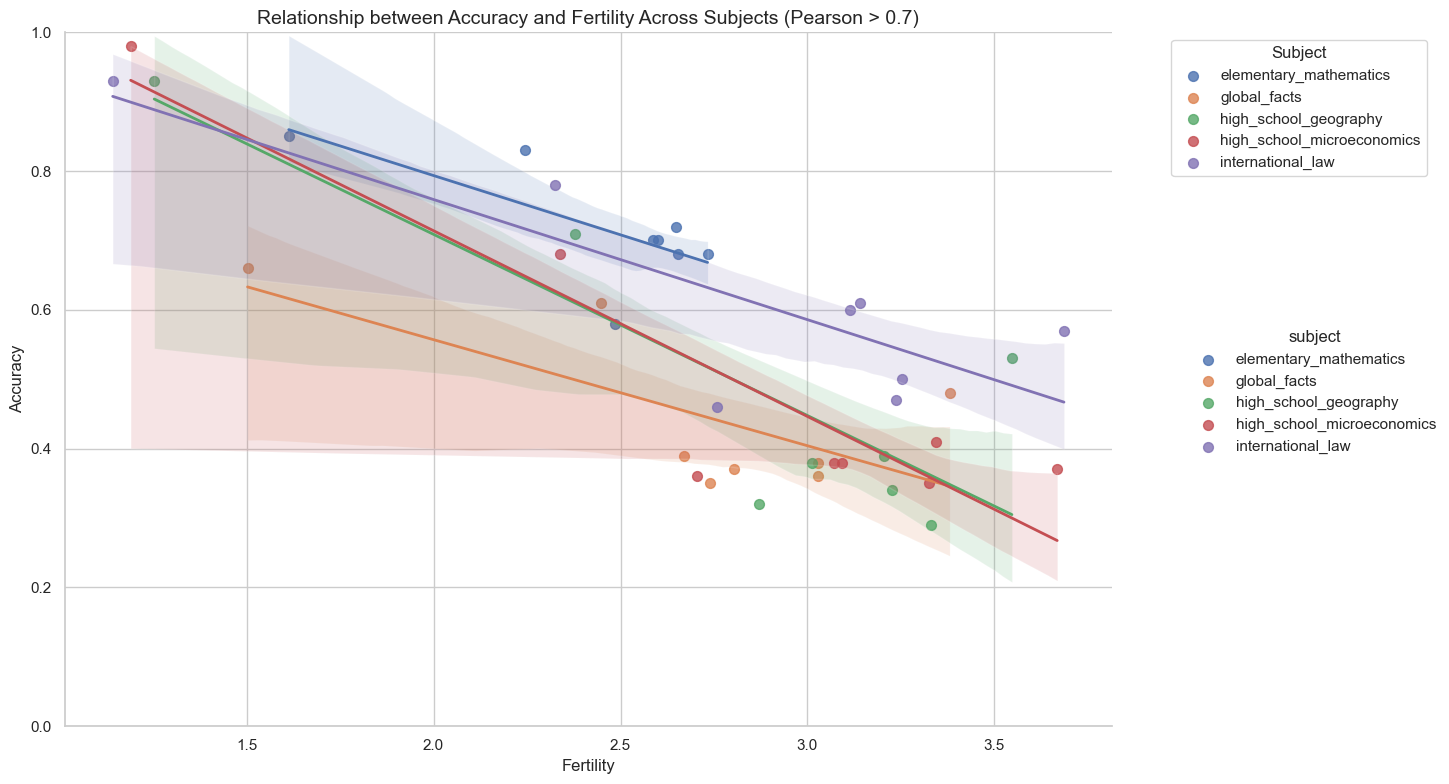

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_df contains the correlations per language
# Filter languages with Pearson correlation > 0.5
valid_languages = correlation_df[abs(correlation_df['correlation']) > 0.6].index

# Filter the original aggregated_df to include only the valid languages
filtered_df = aggregated_df[aggregated_df['language'].isin(valid_languages)]

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=filtered_df,  # Use the filtered dataframe
    x="mean_fertility",
    y="mean_accuracy",
    hue="subject",
    height=8,
    aspect=1.5,
    scatter_kws={"s": 50},
    line_kws={"linewidth": 2},
    ci=80,
)

# Customize the plot
plt.title("Relationship between Accuracy and Fertility Across Subjects (Pearson > 0.7)", fontsize=14)
plt.xlabel("Fertility", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()


In [14]:
print(valid_languages)

Index(['eng', 'ewe', 'lug', 'orm', 'sna', 'swa', 'twi', 'zul'], dtype='object')


Parity 

In [15]:
premiums = {}

# Iterate over the languages and their corresponding subjects
for language, subjects in results_llama_Tokenizer.items():
    premiums[language] = {}
    for subject, value in subjects.items():
        # For each subject, calculate the premium relative to English
        if subject in results_llama_Tokenizer['eng']:
            premium = value / results_llama_Tokenizer['eng'][subject]
            premiums[language][subject] = premium

# Display the calculated premiums
(premiums)

{'amh': {'elementary_mathematics': 4.104332469086891,
  'high_school_geography': 9.112839649141577,
  'international_law': 10.17964944209568,
  'global_facts': 5.867267096527757,
  'high_school_microeconomics': 9.475754397760628},
 'eng': {'global_facts': 1.0,
  'international_law': 1.0,
  'high_school_microeconomics': 1.0,
  'high_school_geography': 1.0,
  'elementary_mathematics': 1.0},
 'ewe': {'elementary_mathematics': 1.5410518192696818,
  'high_school_geography': 2.657505084657974,
  'international_law': 2.834710672601693,
  'global_facts': 1.8240090766266936,
  'high_school_microeconomics': 2.598533532505121},
 'fra': {'elementary_mathematics': 1.1252478758223237,
  'high_school_geography': 1.4416892114923263,
  'international_law': 1.4946215585487046,
  'global_facts': 1.2005587776409345,
  'high_school_microeconomics': 1.3764097138088394},
 'hau': {'elementary_mathematics': 1.3853285775651643,
  'high_school_geography': 1.898127518859519,
  'international_law': 2.1504956171189

In [16]:
def map_parity(row):
    language = row['language']
    subject = row['subject']
    return premiums.get(language, {}).get(subject, None)  # Default to None if not found

# Apply the function to the DataFrame to create a new column 'fertility'
combined_df['parity'] = combined_df.apply(map_parity, axis=1)

# Display the updated DataFrame
# combined_df.to_csv('llama_per_subject_results_parity.csv', index=False)


In [17]:
aggregated_df_parity = combined_df.groupby(['language','subject']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_parity=('parity', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df_parity)

,language,subject,mean_accuracy,mean_parity
0,amh,elementary_mathematics,0.73,4.104332
1,amh,global_facts,0.53,5.867267
2,amh,high_school_geography,0.61,9.112840
3,amh,high_school_microeconomics,0.53,9.475754
4,amh,international_law,0.74,10.179649
...,...,...,...,...
85,zul,elementary_mathematics,0.68,1.694808
86,zul,global_facts,0.48,2.249864
87,zul,high_school_geography,0.53,2.831260
88,zul,high_school_microeconomics,0.37,3.083094


In [18]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming aggregated_df is already loaded and contains the necessary columns

# Group by 'subject' (language) and calculate Pearson correlation per group
correlations = {}

for language, group in aggregated_df_parity.groupby('language'):
    corr, p_value = pearsonr(group['mean_accuracy'], group['mean_parity'])
    correlations[language] = {'correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for easy viewing
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')

print(correlation_df)


     correlation   p_value
amh    -0.100606  0.872122
eng          NaN       NaN
ewe    -0.463918  0.431251
fra     0.595358  0.289496
hau    -0.016325  0.979215
ibo    -0.411060  0.491759
kin    -0.316446  0.603918
lin    -0.275176  0.654109
lug    -0.496453  0.394917
orm    -0.358977  0.552952
sna    -0.435936  0.463068
sot    -0.375140  0.533809
swa    -0.210590  0.733863
twi    -0.642373  0.242486
wol    -0.431954  0.467635
xho    -0.302064  0.621332
yor    -0.301973  0.621441
zul    -0.584776  0.300373


/var/folders/cn/1py0zvm95nx9kp_1_zqwycrm0000gn/T/ipykernel_38484/122986206.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(group['mean_accuracy'], group['mean_parity'])


<Figure size 1200x800 with 0 Axes>

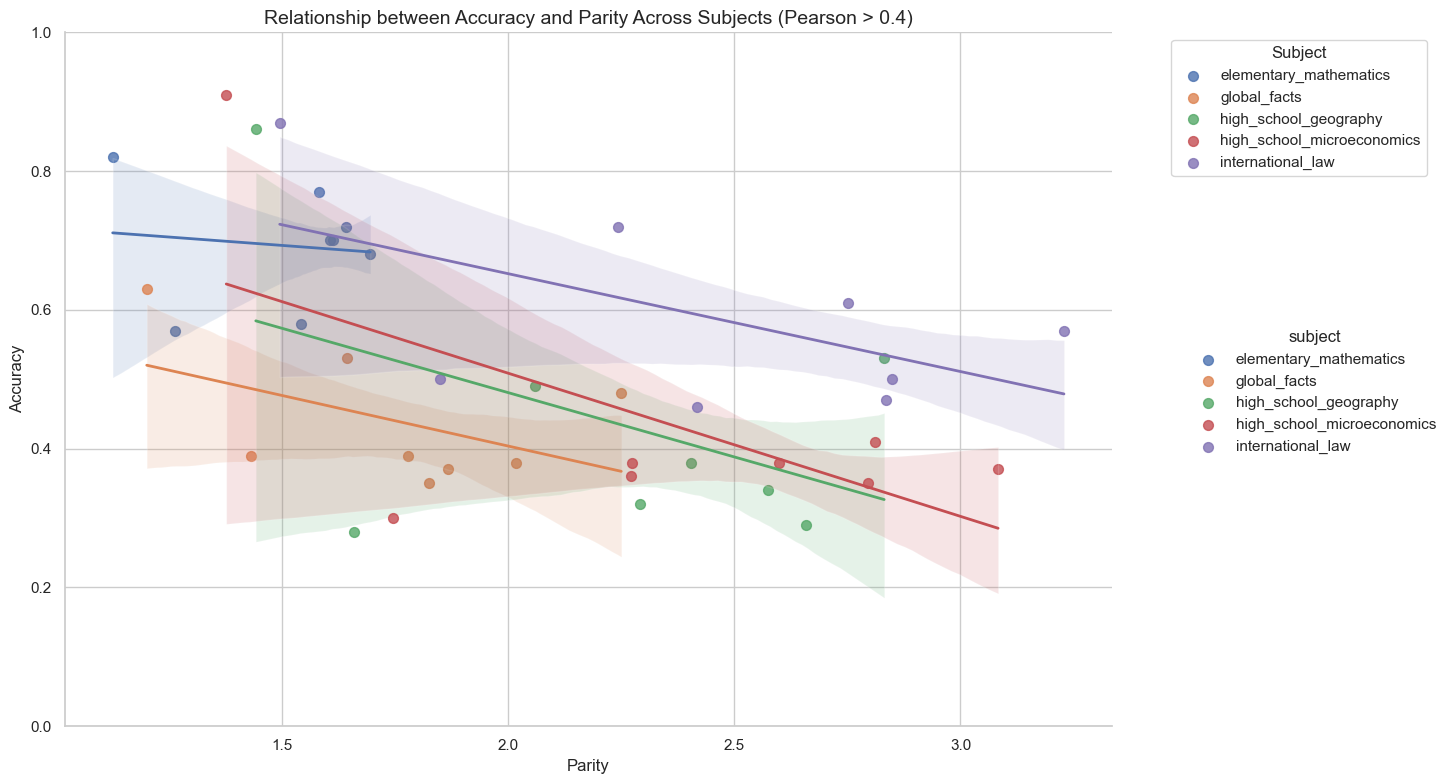

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_df contains the correlations per language
# Filter languages with Pearson correlation > 0.5
valid_languages = correlation_df[abs(correlation_df['correlation']) > 0.4].index

# Filter the original aggregated_df to include only the valid languages
filtered_df = aggregated_df_parity[aggregated_df_parity['language'].isin(valid_languages)]

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=filtered_df,  # Use the filtered dataframe
    x="mean_parity",
    y="mean_accuracy",
    hue="subject",
    height=8,
    aspect=1.5,
    scatter_kws={"s": 50},
    line_kws={"linewidth": 2},
    ci=80,
)

# Customize the plot
plt.title("Relationship between Accuracy and Parity Across Subjects (Pearson > 0.4)", fontsize=14)
plt.xlabel("Parity", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()


" This lack of tokenization parity is not merely a curiosity: it leads to unfairness in the cost to access language models, the latency of the service and the amount of data that can be processed." This affects costs, latency, and tokenization fairness.

In [20]:
print(valid_languages)

Index(['ewe', 'fra', 'ibo', 'lug', 'sna', 'twi', 'wol', 'zul'], dtype='object')


In [21]:
aggregated_df = combined_df.groupby(['language']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_fertility=('fertility', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df)

,language,mean_accuracy,mean_fertility
0,amh,0.628,9.948948
1,eng,0.870,1.339813
2,ewe,0.414,2.976480
3,fra,0.818,1.753639
4,hau,0.546,2.309140
5,ibo,0.578,2.573153
6,kin,0.524,2.851559
7,lin,0.500,1.887116
8,lug,0.464,3.044896
9,orm,0.482,3.014455


Considering both intrinsic and extrinsic evaluation metrics should provide a more comprehensive understanding of a tokenizer's effectiveness and its suitability for specific applications. Should look into that